### IMPORT LIBRARIES

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dowmload de Dataset : https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/"

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical


### Prepare the IRM dataset

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = [176, 208]
EPOCHS = 20

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)



Found 5121 files belonging to 4 classes.
Using 4097 files for training.


In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


### Verify the data

In [18]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

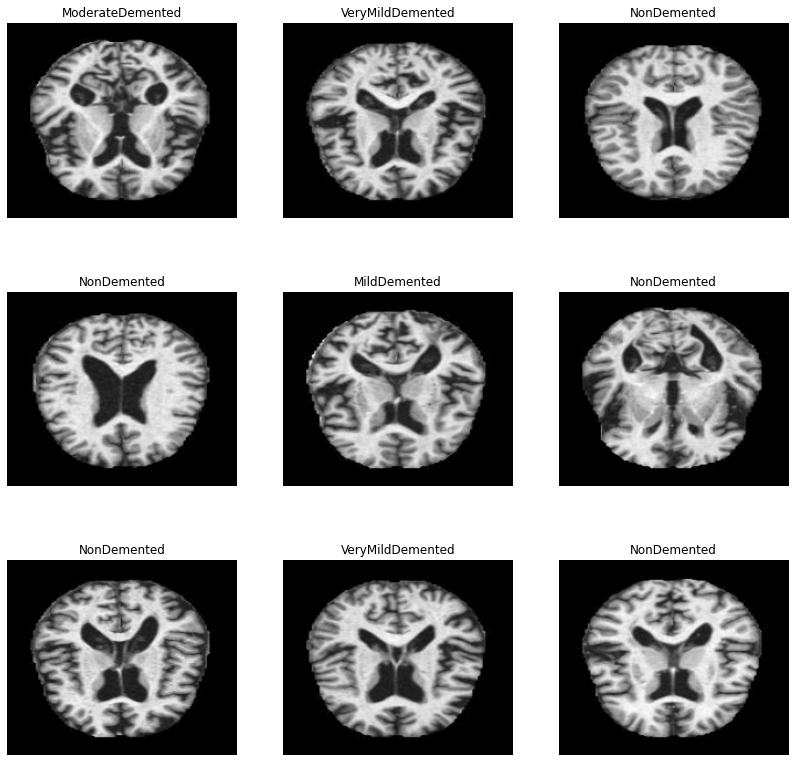

In [19]:
plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [20]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [21]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "/content/drive/MyDrive/Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))



In [23]:
NUM_IMAGES

[717, 52, 2560, 1792]


### Training the Model

### CNN

In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model():
    model_cnn = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model_cnn

In [31]:
model_cnn = build_model()

METRICS = [tf.keras.metrics.AUC(name='auc')]
    
model_cnn.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [32]:

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [33]:
model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 208, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 208, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 104, 16)       0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 52, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 26, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 13, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 13, 128)      

In [52]:
history1 = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/20
257/257 [==============================] - 16s 62ms/step - loss: 0.3062 - auc: 0.9827 - val_loss: 5.7157 - val_auc: 0.9163
Epoch 2/20
257/257 [==============================] - 16s 63ms/step - loss: 0.2487 - auc: 0.9877 - val_loss: 0.9041 - val_auc: 0.9293
Epoch 3/20
257/257 [==============================] - 16s 63ms/step - loss: 0.2115 - auc: 0.9901 - val_loss: 0.4391 - val_auc: 0.9739
Epoch 4/20
257/257 [==============================] - 16s 63ms/step - loss: 0.3212 - auc: 0.9815 - val_loss: 1.9626 - val_auc: 0.8382
Epoch 5/20
257/257 [==============================] - 16s 63ms/step - loss: 0.2711 - auc: 0.9858 - val_loss: 0.2240 - val_auc: 0.9892
Epoch 6/20
257/257 [==============================] - 16s 63ms/step - loss: 0.2304 - auc: 0.9892 - val_loss: 3.1369 - val_auc: 0.9690
Epoch 7/20
257/257 [==============================] - 16s 64ms/step - loss: 0.2008 - auc: 0.9913 - val_loss: 0.3721 - val_auc: 0.9775
Epoch 8/20
257/257 [==============================] - 16s 64ms

### RESNET50

In [ ]:

base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")
from tensorflow.keras.utils import to_categorical

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)


test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:

base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
model1=tf.keras.Sequential()
model1.add(base_model)
model1.add(Dropout(0.5))
model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(2048,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1024,kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4,activation='softmax'))

In [ ]:
model1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout_10 (Dropout)         (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 100352)            401408    
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_15 (Batc (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)            

In [ ]:
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc',tensorflow.keras.metrics.AUC(name = 'auc'),tensorflow.keras.metrics.AUC(name = 'roc')])

In [ ]:
history2=model1.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        verbose = 1)

Epoch 1/50
129/129 [==============================] - 34s 234ms/step - loss: 1.4474 - acc: 0.5308 - auc: 0.7822 - roc: 0.7822 - val_loss: 1.7208 - val_acc: 0.4360 - val_auc: 0.7431 - val_roc: 0.7431
Epoch 2/50
129/129 [==============================] - 28s 221ms/step - loss: 0.9330 - acc: 0.6330 - auc: 0.8707 - roc: 0.8707 - val_loss: 1.2033 - val_acc: 0.4506 - val_auc: 0.7800 - val_roc: 0.7800
Epoch 3/50
129/129 [==============================] - 29s 222ms/step - loss: 0.8017 - acc: 0.6735 - auc: 0.8956 - roc: 0.8956 - val_loss: 1.3770 - val_acc: 0.4457 - val_auc: 0.7681 - val_roc: 0.7681
Epoch 4/50
129/129 [==============================] - 29s 222ms/step - loss: 0.7319 - acc: 0.7051 - auc: 0.9095 - roc: 0.9095 - val_loss: 0.9769 - val_acc: 0.5435 - val_auc: 0.8455 - val_roc: 0.8455
Epoch 5/50
129/129 [==============================] - 29s 223ms/step - loss: 0.6444 - acc: 0.7343 - auc: 0.9289 - roc: 0.9289 - val_loss: 0.9928 - val_acc: 0.6080 - val_auc: 0.8686 - val_roc: 0.8686
Epoch


### Visualizing Model Metrics


### CNN

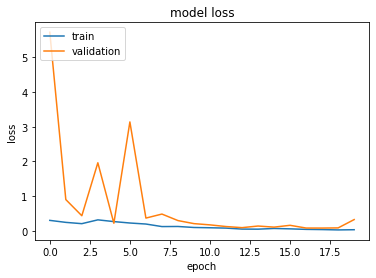

In [53]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

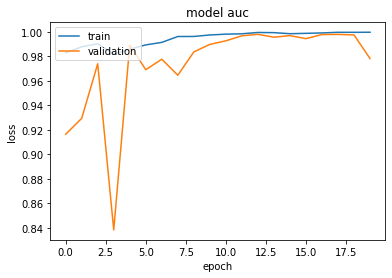

In [54]:
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('model auc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### ResNet50

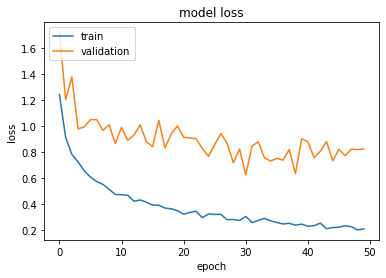

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

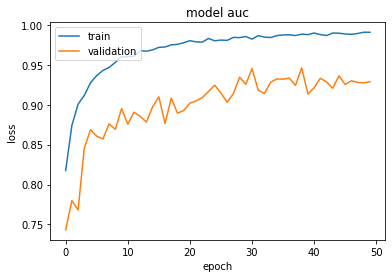

In [ ]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('model auc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate the Model

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
model.evaluate(test_ds)

80/80 [==============================] - 281s 3s/step - loss: 1.2720 - auc: 0.8567


[1.2719841003417969, 0.8566747307777405]

In [ ]:
model1.evaluate(test_dataset)

40/40 [==============================] - 4s 109ms/step - loss: 1.4305 - acc: 0.6466 - auc: 0.8591 - roc: 0.8591


[1.4305120706558228,
 0.6465989351272583,
 0.8590656518936157,
 0.8590656518936157]